In [3]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import numba
from scipy.special import kv
import progressbar
%matplotlib inline

In [4]:
a,b=0.5,0.5;
NG=40;
NX=100;
X=np.linspace(0,a+b,NX+1);X=np.delete(X,-1)
G=2*np.pi*np.arange(-NG/2,NG/2)/(a+b)
NK=80; #number of k-points
K=np.arange(-NK/2,NK/2)/(a+b)*2*np.pi/NK
V0=20
A=0.25
alpha=0.01
Volume=NK*(a+b)
step=1

In [5]:
G_max=2*np.pi/(a+b)*NG

In [6]:
basis=np.exp(1j*G[None,:]*X[:,None])
V=np.diag(V0*(X<b))
Vext=basis.T.conj().dot(V).dot(basis)/NX

In [7]:
Ek,Dk=[],[]
bar=progressbar.ProgressBar()
for i in bar(range(NK)):
    H=Vext+np.diag(G+K[i])**2/2.
    E,D=np.linalg.eigh(H)
    Ek.append(E);Dk.append(D)
Ek=np.array(Ek);Dk=np.array(Dk)

100% |########################################################################|


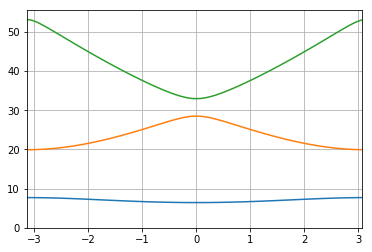

In [8]:
plt.figure()
for i in range(3):
    plt.plot(K,Ek[:,i].real,'-')
plt.ylim([0,None])
plt.xlim([np.min(K),np.max(K)])
plt.grid()

In [9]:
E_GAP=np.min(Ek[:,2]-Ek[:,1])

In [10]:
E_GAP

4.435124301528777

In [11]:

E_Fermi=np.max(Ek[:,step])
indexes=[(n,k) for n,k in product(range(4),range(NK))]
N=len(indexes)

rho=np.zeros((N,N,NG),dtype=np.complex)
bar=progressbar.ProgressBar()
for i1 in bar(range(N)):
    n1,k1=indexes[i1]
    for i2 in range(N):
        n2,k2=indexes[i2]
        wf1=np.fft.ifft(Dk[k1,:,n1])
        wf2=np.fft.ifft(Dk[k2,:,n2])
        rho[i1,i2]=np.fft.fftshift(np.fft.fft(wf2*wf1.conj()))*NG      

100% |########################################################################|


In [12]:
K_index=np.arange(-NK,NK)
def find_q(k1,k2):
    return np.where(K_index==(k1-k2))[0]
q=np.zeros((NK,NK))
for i in range(NK):
    for j in range(NK):
        q[i,j]=int(find_q(i,j)[0])      

In [13]:
V=np.zeros((NK,NG,NG))
for i in range(NK):
    V[i]=2*A*np.diag(kv(0,np.sqrt(alpha)*np.abs(K[i]+G)))
V[NK/2,NG/2,NG/2]=0

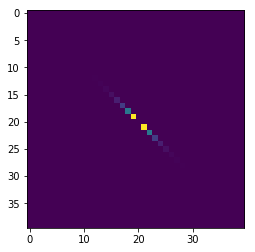

In [14]:
plt.imshow(V[NK/2])

In [15]:
indexes=[(n,k) for n,k in product([1,2],range(NK))]
N=len(indexes)
K_full=np.arange(-NK,NK)/(a+b)*2*np.pi/NK
V=np.zeros((2*NK,NG,NG))
for i in range(2*NK):
    V[i]=2*A*np.diag(kv(0,np.sqrt(alpha)*np.abs(K_full[i]+G)))
V[V==np.inf]=0
chi0=np.zeros((2*NK,NG,NG),dtype=np.complex)
bar=progressbar.ProgressBar()
for i1 in bar(range(N)):
    n1,k1=indexes[i1]
    f1=int(Ek[k1,n1]<=E_Fermi)
    for i2 in range(N):
        n2,k2=indexes[i2]
        f2=int(Ek[k2,n2]<=E_Fermi)
        if (f1-f2)!=0 and q[k1,k2]!=np.inf:
            element=2*(f1-f2)
            element*=rho[i1,i2,:,None]*rho[i1,i2,None,:]
            element/=Ek[k1,n1]-Ek[k2,n2]
            chi0[int(q[k1,k2])]+=element
chi0/=NK
W=np.zeros_like(chi0)
epsilon=np.zeros_like(chi0)
bar=progressbar.ProgressBar()
for i in bar(range(2*NK)):
    epsilon[i]=np.eye(NG)-np.dot(V[i],chi0[i])
    W[i]=np.dot(np.linalg.inv(epsilon[i]),V[i])

100% |########################################################################|
100% |########################################################################|


/usr/local/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


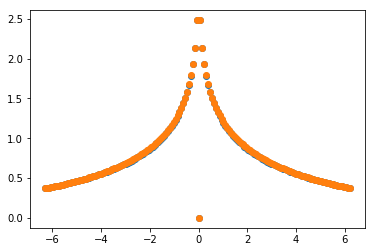

In [16]:
plt.plot(K_full,W[:,NG/2,NG/2],'o')
plt.plot(K_full,V[:,NG/2,NG/2],'o')
# plt.xlim([0,np.pi/(a+b)])

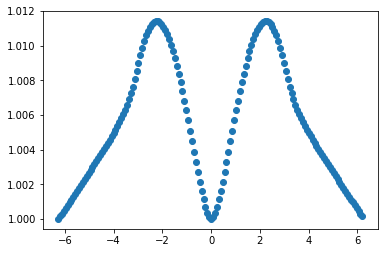

In [17]:
plt.plot(K_full,epsilon[:,NG/2,NG/2],'o')

In [26]:
V=2*A*np.diag(kv(0,np.sqrt(alpha)*np.abs(G)))
V[np.abs(V)==np.inf]=0
rho=rho.reshape((4,NK,4,NK,NG)) 
indexes=[(1,2,k) for k in range(NK)]
N=len(indexes)

alpha_SC=0.01
A_SC=-2.39
A=-2.32

fxc=2*A_SC*np.diag(kv(0,np.sqrt(alpha_SC)*np.abs(G)))
fxc[np.abs(fxc)==np.inf]=0

F_TDDFT=np.zeros((N,N),dtype=np.complex)
F_ALDA=np.zeros((N,N),dtype=np.complex)
F_BSE=np.zeros((N,N),dtype=np.complex)
F_Free=np.zeros((N,N),dtype=np.complex)
bar=progressbar.ProgressBar()
for i1 in bar(range(N)):
    v1,c1,k1=indexes[i1]
#     F_TDDFT[i1,i1]=Ek[k1,c1]-Ek[k1,v1]
#     F_ALDA[i1,i1]=Ek[k1,c1]-Ek[k1,v1]
#     F_BSE[i1,i1]=Ek[k1,c1]-Ek[k1,v1]
#     F_Free[i1,i1]=Ek[k1,c1]-Ek[k1,v1]
    for i2 in range(N):
        v2,c2,k2=indexes[i2]
        rho1=rho[v1,k1,c1,k1];rho2=rho[v2,k2,c2,k2].conj()
        Hartree=2*np.einsum('i,ii,i',rho1,V,rho2)
        F_TDDFT[i1,i2]+=Hartree+2*np.einsum('i,ii,i',rho1,fxc,rho2)
        F_ALDA[i1,i2]+=Hartree+2*A*np.einsum('i,i',rho1,rho2)
        rho3=rho[v1,k1,v2,k2];rho4=rho[c1,k1,c2,k2].conj()
        F_BSE[i1,i2]+=Hartree-np.einsum('i,ij,j',rho3,W[int(q[k1,k2])],rho4)

100% |########################################################################|


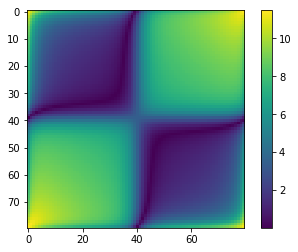

In [27]:
plt.imshow(np.abs(F_TDDFT)[::-1])
plt.colorbar()

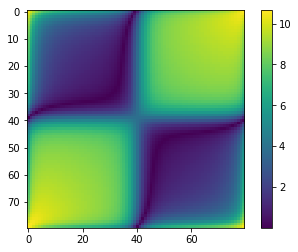

In [28]:
plt.imshow(np.abs(F_ALDA)[::-1])
plt.colorbar()

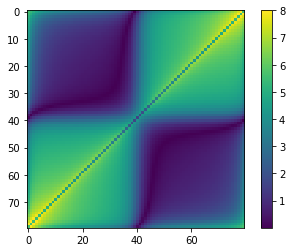

In [29]:
plt.imshow(np.abs(F_BSE)[::-1])
plt.colorbar()

In [22]:
E,D=np.linalg.eigh(F_BSE)

In [23]:
E-E_GAP

array([-31.24360072, -16.0421164 ,  -5.0747777 ,  -0.13669318,
         1.12164212,   2.0793188 ,   2.39475121,   2.70937917,
         2.73648732,   3.08967513,   3.14803925,   3.64527919,
         3.71887847,   4.30039868,   4.38412053,   5.02020657,
         5.11125297,   5.78430964,   5.88091793,   6.57971684,
         6.68070871,   7.39775882,   7.50230922,   8.23243535,
         8.33994057,   9.07945808,   9.18945628,   9.93566981,
        10.04779168,  10.79867959,  10.91261736,  11.66662634,
        11.78211451,  12.53802161,  12.65482572,  13.41164257,
        13.52955334,  14.28645847,  14.40528816,  15.16158003,
        15.28115641,  16.03622352,  16.15637778,  16.90967925,
        17.03023534,  17.78128221,  17.9020591 ,  18.65039379,
        18.77121106,  19.51638864,  19.63706736,  20.37863865,
        20.49900369,  21.23649511,  21.35638199,  22.08926698,
        22.20853657,  22.93619149,  23.05475954,  23.77639127,
        23.89428546,  24.60880964,  24.72627695,  25.43

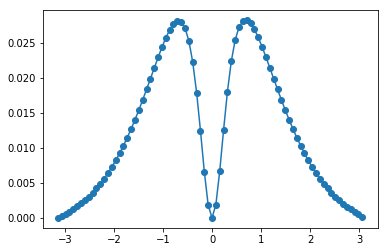

In [25]:
plt.plot(K,np.abs(D[:,1])**2,'-o')